# **Introducing a custom Reinforcement Learning - Sequential Sampling Model (RLSSM) into HSSM**

Before proceeding with this tutorial, we recommend going through the main RLSSM tutorial (Tutorial for hierarchical Bayesian inference for Reinforcement Learning - Sequential Sampling Models for a general familiarity with RLSSM modeling in HSSM. 

This tutorial demonstrates how to incorporate custom, user-defined Reinforcement Learning Sequential Sampling Models (RLSSM) into the HSSM framework by modifying the `rldm.py` file. The tutorial walks through the key steps needed to define, implement, and integrate your custom RLSSM likelihood functions. 

More specifically, this tutorial shows how to add a custom model on a 2-armed bandit environment. Our model employs simple Rescorla-Wagner-style learning updates with two learning rates - for positive and negative prediction errors. The decision process is a drift-diffusion model with collapsing bounds ('angle' model). 

> # ⚠️ **Warning** 

You will have to edit `rldm.py` file and re-install hssm for this tutorial to work. Running this notebook without changes to the `rldm.py` file will throw errors. 

In [15]:
# Import necessary libraries
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from functools import partial

# Import HSSM and simulator package
import hssm
from hssm.utils import decorate_atomic_simulator
from hssm.likelihoods.rldm import make_rldm_logp_op
from hssm.distribution_utils.dist import make_hssm_rv
from ssms.basic_simulators.simulator import simulator

In [2]:
# Set the style for the plots
plt.style.use('seaborn-v0_8-dark-palette')

# **Section I: Introduce the likelihood function for your custom model in HSSM**

In the existing implementation, `rldm.py` already defines the model config (Step 1) and the likelihood function (Step 3) for the model mentioned above. The model is called `rlssm2` in the existing implementation. An easy way to follow this tutorial is simply considering `rlssm2` as your custom model that you want to incoporate into HSSM. Make the necessary changes outlined in steps 2, 4 and 5 to readily use the implemented model. 

### Step 1: Define Your Custom RLSSM Model Configuration

**Location**: Add to the `rlssm_model_config_list` dictionary

**Purpose**: Define the meta-data and parameters of your custom model in a configuration dictionary.

**Details**:
- Create a new entry in the `rlssm_model_config_list` dictionary with a unique model name
- Specify the following required fields:
  - `name`: Name your custom rlssm model
  - `description`: Optional description of the model
  - `n_params`: Number of model parameters 
  - `n_extra_fields`: Number of extra_fields columns passed to the likelihood function (e.g., trial, feedback)
  - `list_params`: List of parameter names in the order they'll be passed to the likelihood function
  - `extra_fields`: List of extra_fields columns
  - `decision_model`: Type of the likelihood for the decision process model (typically "LAN" - likelihood approximation networks)
  - `LAN`: Specific LAN model to use (e.g., "angle")

**Example**:
```python
"my_custom_rlssm": {
    "name": "my_custom_rlssm", 
    "description": "Custom RLSSM with special features", 
    "n_params": 8, 
    "n_extra_fields": 3, 
    "list_params": ["param1", "param2", "param3", ...], 
    "extra_fields": ["extra_fields1", "extra_fields2", "extra_fields3", ...], 
    "decision_model": "LAN", 
    "LAN": "angle", 
}

### Step 2: Specify Which Model Configuration to Use



**Location**: Update the `MODEL_NAME` variable



**Purpose**: Inform the HSSM package which model configuration to use from your defined list.



**Details**:

- Set `MODEL_NAME` to match one of the keys in your `rlssm_model_config_list` dictionary

- The system will automatically load the corresponding configuration

- This makes it easy to switch between different model variants



**Example**:

```python

MODEL_NAME = "my_custom_rlssm"  # Must match a key in rlssm_model_config_list

```

### Step 3: Implement Your Custom Likelihood Function

**Location**: Create a new function following the naming pattern `{model_name}_logp_inner_func`

**Purpose**: Define the core computational logic for your RLSSM model. See the existing implementation in `rldm.py` for template details.

**Details**:
- **Function signature**: Must follow the pattern:
  ```python
  def my_custom_rlssm_logp_inner_func(
      subj,
      ntrials_subj,
      data,
      *model_params,    # Your specific parameters
      *extra_fields,    # Additional data fields
  ):
  ```
- **Input requirements**:
  - `subj`: Subject index
  - `ntrials_subj`: Number of trials per subject
  - `data`: RT and response data matrix
  - Parameters must match the order specified in `list_params`
  - Extra fields must match those specified in `extra_fields`

- **Output requirements**:
  - Return a 1D array of log likelihoods for each trial
  - Must be differentiable for gradient-based sampling/optimization

- **Implementation notes**:
  - Use JAX operations for automatic differentiation
  - Handle parameter slicing for individual subjects using `dynamic_slice`
  - Implement your specific RL update rules and decision mechanisms
  - Structure the LAN matrix according to your decision model requirements

### Step 4: Update the Vectorized Function Reference

**Location**: Modify the `rldm_logp_inner_func_vmapped` assignment

**Purpose**: Enable parallel computation across multiple subjects.

**Details**:
- Update the function reference to point to your custom likelihood function
- The vectorization pattern remains the same - only the first argument (subject index) gets vectorized
- Ensure the `total_params` count includes all parameters plus extra fields plus data columns

**Example**:
```python
rldm_logp_inner_func_vmapped = jax.vmap(
    my_custom_rlssm_logp_inner_func,  # Update this to your function name
    in_axes=[0] + [None] * total_params,
)
```

### Step 5: Update Parameter Unpacking in the Main Likelihood Function

**Location**: Modify the `logp` function within `make_logp_func`

**Purpose**: Ensure parameters are correctly extracted and passed to your custom function.

**Details**:
- **Parameter extraction**: Adjust the indexing to match your model's parameter structure:
  ```python
  # Extract extra fields (adjust indices based on your model)
  participant_id = dist_params[n_params]      # Usually after all model params
  trial = dist_params[n_params + 1]
  feedback = dist_params[n_params + 2]
  # ... additional extra fields as needed
  
  # Extract model parameters
  param1, param2, ..., paramN = dist_params[:MODEL_CONFIG["n_params"]]
  ```

- **Function call**: Update the `vec_logp` call to pass parameters in the correct order:
  ```python
  return vec_logp(
      subj,
      n_trials,
      data,
      param1,    # Your specific parameters
      param2,
      # ...
      paramN,
      trial,     # Extra fields
      feedback,
      # ...
  )
  ```

### Step 6: Verify VJP Function Compatibility

**Location**: Check the `vjp_logp` function within `make_vjp_logp_func`

**Purpose**: Ensure gradient computation works correctly with your parameter structure.

**Details**:
- The VJP (Vector-Jacobian Product) function should automatically work with your custom model
- The slicing `[1:MODEL_CONFIG["n_params"] + 1]` excludes the data and extra fields from gradient computation
- No changes typically needed unless you have special gradient requirements

**Notes**:
- VJP is used for automatic differentiation during MCMC sampling
- The function computes gradients with respect to model parameters only
- Extra fields (trial, feedback, etc.) are not differentiated
- If your model has unusual parameter dependencies, you may need custom gradient handling

# **Section II: Using the custom model with HSSM**

## Load and prepare the demo dataset
This data file contains (synthetic) data from a simulated 2-armed bandit task. We examine the dataset -- it contains the typical columns that are expected from a canonical instrumental learning task. `participant_id` identifies the subject id, `trial` identifies the sequence of trials within the subject data, `response` and `rt` are the data columns recorded for each trial, `feedback` column shows the reward obtained on a given trial and `correct` records whether the response was correct. 

In [3]:
# Load synthetic RLSSM dataset containing both behavioral data and ground truth parameters
savefile = np.load("../../tests/fixtures/rldm_data.npy", allow_pickle=True).item()
dataset = savefile['data']

# Rename trial column to match HSSM conventions
dataset.rename(columns={'trial': 'trial_id'}, inplace=True)

# Examine the dataset structure
dataset.head()

,participant_id,trial_id,response,rt,feedback,correct
0,0,0,0.0,0.935602,0.126686,0.0
1,0,1,0.0,1.114379,0.173100,0.0
2,0,2,0.0,0.564311,0.444935,0.0
3,0,3,0.0,2.885860,0.307207,0.0
4,0,4,0.0,0.532113,0.177911,0.0


In [4]:
# Validate data structure and extract dataset configuration 
dataset, n_participants, n_trials = hssm.check_data_for_rl(dataset)

print(f"Number of participants: {n_participants}")
print(f"Number of trials: {n_trials}")

Number of participants: 20
Number of trials: 200


# Construct HSSM-compatible PyMC distribution from a simulator and JAX likelihood callable

We now construct a custom model that is compatible with HSSM and PyMC. Note that HSSM internally constructs a PyMC object (which is used for sampling) based on the user-specified HSSM model. In other words, we are peeling the abstration layers conveniently afforded by HSSM to directly use the core machinery of HSSM. This advanced [HSSM tutorial](https://lnccbrown.github.io/HSSM/tutorials/jax_callable_contribution_onnx_example/) explains how to use HSSM when starting from the very basics of a model -- a simulator and a JAX likelihood callable. 

The simulator function is used for generating samples from the model (for posterior predictives, etc.) and the likelihood callable is employed for sampling/inference. This preview tutorial exposes the key flexibility of the HSSM for use in fitting RLSSM models. Therefore, the subsequent tutorial will focus only on the sampling/inference aspect. We create a dummy simulator function to bypass the need for defining the actual simulator.

### Step 1: Define a pytensor RandomVariable

In [5]:
# Define parameters for the RLSSM model (RL + decision model parameters)
list_params = ['rl.alpha', 'rl.alpha_neg', 'scaler', 'a', 'z', 't', 'theta']

# Create a dummy simulator for generating synthetic data (used for posterior predictives)
# This bypasses the need for a full RLSSM simulator implementation
def create_dummy_simulator():
    """Create a dummy simulator function for RLSSM model."""
    def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):
        # Generate random RT and choice data as placeholders
        sim_rt = np.random.uniform(0.2, 0.6, n_samples)
        sim_ch = np.random.randint(0, 2, n_samples)
        
        return np.column_stack([sim_rt, sim_ch])

    # Wrap the simulator function with required metadata
    wrapped_simulator = partial(sim_wrapper, simulator_fun=simulator, model="custom", n_samples=1)

    # Decorate the simulator to make it compatible with HSSM
    return decorate_atomic_simulator(model_name="custom", choices=[0, 1], obs_dim=2)(wrapped_simulator)

# Create the simulator and RandomVariable
decorated_simulator = create_dummy_simulator()

# Create a PyTensor RandomVariable using `make_hssm_rv` for use in the PyMC model
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=list_params
)

### Step 2: Define a likelihood function

In [6]:
# Create a Pytensor Op for the likelihood function.
# The `make_rldm_logp_op` function is a utility that wraps the base JAX likelihood function into a HSSM/PyMC-compatible callable.

logp_jax_op = make_rldm_logp_op(
    n_participants=n_participants,
    n_trials=n_trials,
    n_params=len(list_params),
)

In [7]:
# Test the likelihood function

def extract_data_columns(dataset):
    """Extract required data columns from dataset."""
    return {
        'participant_id': dataset["participant_id"].values,
        'trial': dataset["trial_id"].values,
        'response': dataset["response"].values,
        'feedback': dataset["feedback"].values,
        'rt': dataset["rt"].values
    }

def create_test_parameters(n_trials):
    """Create dummy parameters for testing the likelihood function."""
    return {
        'rl_alpha': np.ones(n_trials) * 0.60,
        'rl_alpha_neg': np.ones(n_trials) * 0.60,  
        'scaler': np.ones(n_trials) * 3.2,
        'a': np.ones(n_trials) * 1.2,
        'z': np.ones(n_trials) * 0.1,
        't': np.ones(n_trials) * 0.1,
        'theta': np.ones(n_trials) * 0.1
}

# Extract data and create test parameters
data_columns = extract_data_columns(dataset)
num_subj = len(np.unique(data_columns['participant_id']))
n_trials_total = num_subj * 200

test_params = create_test_parameters(n_trials_total)

# Evaluate the likelihood function
test_logp_out = logp_jax_op(
    np.column_stack((data_columns['rt'], data_columns['response'])),
    test_params['rl_alpha'],
    test_params['rl_alpha_neg'],
    test_params['scaler'],
    test_params['a'], 
    test_params['z'],
    test_params['t'],
    test_params['theta'],
    data_columns['participant_id'],
    data_columns['trial'],
    data_columns['feedback'],
)

LL = test_logp_out.eval()
print(f"Log likelihood: {np.sum(LL):.4f}")

Log likelihood: -6879.1526


### Step 3: Define a model config and HSSM model

In [8]:
# Step 3: Define the model config

# Configure the HSSM model 
model_config = hssm.ModelConfig(
    response=["rt", "response"],        # Dependent variables (RT and choice)
    list_params=                        # List of model parameters
        ['rl.alpha', 'rl.alpha_neg', 'scaler', 'a', 'z', 't', 'theta'],            
    choices=[0, 1],                     # Possible choice options
    default_priors={},                  # Use custom priors (defined below)
    bounds=dict(                        # Parameter bounds for optimization
        rl_alpha=(0.01, 1),             # Learning rate bounds
        rl_alpha_neg=(0.01, 1),         # Negative learning rate bounds
        scaler=(1, 4),                  # Scaler bounds
        a=(0.3, 2.5),                   # Boundary separation bounds
        z=(0.1, 0.9),                   # Bias bounds
        t=(0.1, 2.0),                   # Non-decision time bounds
        theta=(0.0, 1.2)                # Collapse rate bounds
        ),
    rv=CustomRV,                        # Custom RandomVariable that we created earlier
    extra_fields=[                      # Additional data columns to be passed to the likelihood function as extra_fields
        "participant_id", 
        "trial_id", 
        "feedback"],  
    backend="jax"                       # Use JAX for computation
)

In [9]:
# Create a hierarchical HSSM model with custom likelihood function
hssm_model = hssm.HSSM(
    data=dataset,                        # Input dataset
    model_config=model_config,           # Model configuration
    p_outlier=0,                         # No outlier modeling
    lapse=None,                          # No lapse rate modeling
    loglik=logp_jax_op,                  # Custom RLDM likelihood function
    loglik_kind="approx_differentiable", # Use approximate gradients
    noncentered=True,                    # Use non-centered parameterization
    process_initvals=False,              # Skip initial value processing in HSSM
    include=[
        # Define hierarchical priors: group-level intercepts + subject-level random effects
        hssm.Param("rl.alpha", 
                formula="rl_alpha ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.01, upper=1, mu=0.3)}),
        hssm.Param("rl.alpha_neg", 
                formula="rl_alpha_neg ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.01, upper=1, mu=0.3)}),
        hssm.Param("scaler", 
                formula="scaler ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=1, upper=4, mu=1.5)}),
        hssm.Param("a", 
                formula="a ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.3, upper=2.5, mu=1.0)}),
        hssm.Param("z", 
                formula="z ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.1, upper=0.9, mu=0.2)}),
        hssm.Param("t", 
                formula="t ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.01, upper=2, mu=0.2, initval=0.1)}),
        hssm.Param("theta", 
                formula="theta ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.00, upper=1.2, mu=0.3)}),
    ]
)

No common intercept. Bounds for parameter rl.alpha is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter rl.alpha_neg is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter scaler is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter a is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter z is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter t is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter theta is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


# Sample using NUTS MCMC

In [ ]:
# Run MCMC sampling using NUTS sampler with JAX backend
# Note: Using small number of samples for demonstration (increase for real analysis)
idata_mcmc = hssm_model.sample(
    sampler='numpyro',  # JAX-based NUTS sampler for efficiency
    chains=1,                # Number of parallel chains
    draws=1000,                # Number of posterior samples
    tune=1000,                 # Number of tuning/warmup samples
)

Using default initvals. 



sample: 100%|██████████| 2000/2000 [08:33<00:00,  3.89it/s, 29 steps of size 1.56e-01. acc. prob=0.92]   
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/krishnbera/Documents/revert_rldm/HSSM/.venv/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 1000/1000 [00:02<00:00, 366.61it/s]


In [11]:
idata_mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Assess the model fits

We examine the quality of fits by comparing the recovered parameters with the ground-truth data generating parameters of the simulated dataset. 
We examine the quality of fits both at group-level as well as subject-level.

## Examining group-level posteriors

In [12]:
# Define parameter names for analysis

list_group_mean_params = [
    "rl.alpha_Intercept",
    "rl.alpha_neg_Intercept",
    "scaler_Intercept",
    "a_Intercept",
    "z_Intercept",
    "t_Intercept",
    "theta_Intercept",
]

list_group_sd_params = [
    "rl.alpha_1|participant_id_sigma",
    "rl.alpha_neg_1|participant_id_sigma",
    "scaler_1|participant_id_sigma",
    "a_1|participant_id_sigma", 
    "z_1|participant_id_sigma",
    "t_1|participant_id_sigma",
    "theta_1|participant_id_sigma",
]

In [13]:
# Create mapping from HSSM model parameter names to ground truth values.
def create_ground_truth_mapping(savefile):

    return {
    "rl.alpha_Intercept": savefile['params_true_group']['rl_alpha_mean'],
    "scaler_Intercept": savefile['params_true_group']['scaler_mean'],
    "a_Intercept": savefile['params_true_group']['a_mean'],
    "z_Intercept": savefile['params_true_group']['z_mean'],
    "t_Intercept": savefile['params_true_group']['t_mean'],
    "theta_Intercept": savefile['params_true_group']['theta_mean'],
}

ground_truth_params = create_ground_truth_mapping(savefile)
print("Ground truth group means:\n")
for param, value in ground_truth_params.items():
    print(f"{param}: {value:.3f}")

Ground truth group means:

rl.alpha_Intercept: 0.660
scaler_Intercept: 2.785
a_Intercept: 1.481
z_Intercept: 0.267
t_Intercept: 0.443
theta_Intercept: 0.312


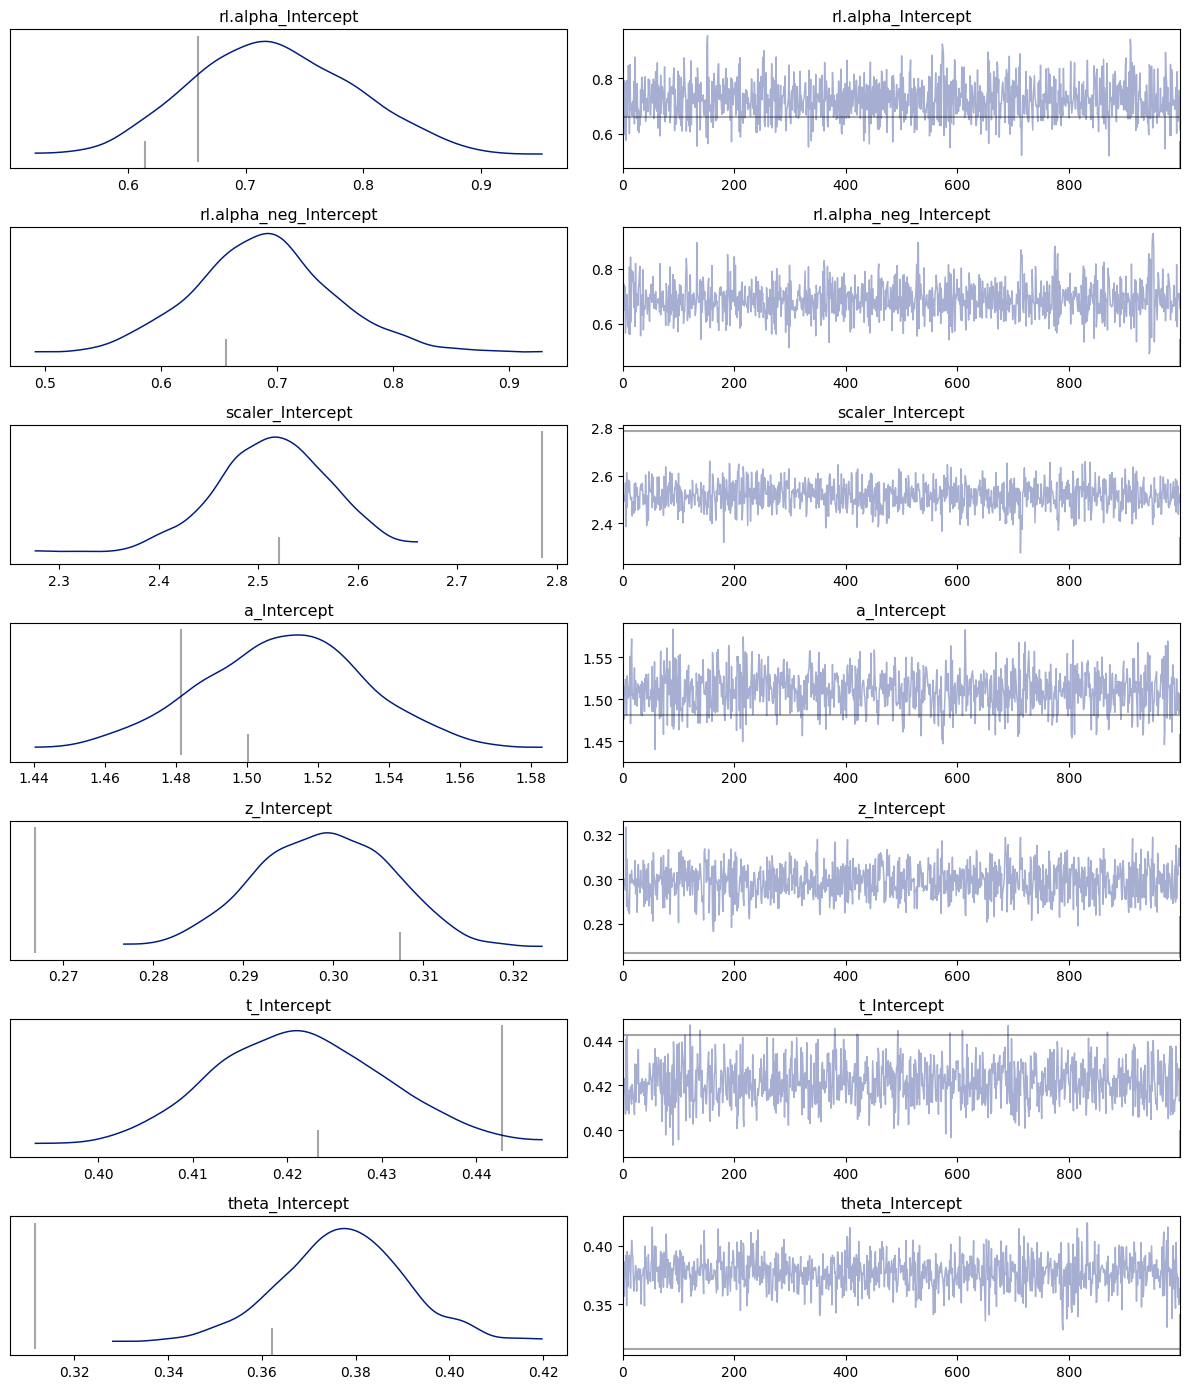

In [14]:
# Plot posterior distributions and MCMC traces for group-level parameters
# Vertical lines show ground truth values for parameter recovery assessment
az.plot_trace(idata_mcmc, var_names=list_group_mean_params,
              lines=[(key_, {}, ground_truth_params[key_]) for key_ in ground_truth_params])
plt.tight_layout()